In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
# Load the dataset
df_ben_ddos = pd.read_csv('dataset/df_ben_ddos.csv')
df_ben_ddos

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,1098,48438,12963,23,1,5.030600,4,1,60,0,0,0
1,1098,33878,59500,23,1,3.089012,4,3,180,0,0,0
2,1098,55416,62742,23,1,3.089276,4,3,180,0,0,0
3,1098,47778,11680,23,1,5.030600,4,1,60,0,0,0
4,1098,46752,1504,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,1097,59699,22203,62336,1,5.030600,0,0,0,0,0,1
2314091,1097,32909,22203,62336,1,5.030600,0,0,0,0,0,1
2314092,1097,25120,22203,62336,1,5.030600,0,0,0,0,0,1
2314093,1097,30340,22203,62336,1,5.030600,0,0,0,0,0,1


In [18]:
# Sampled dataset, it could be either random rows or 10k from beningn and 10k from malicious to balance the trained dataset
#df_sampled = df_ben_ddos.sample(frac=0.01, random_state=42)
df_first = df_ben_ddos.head(10000)
df_last = df_ben_ddos.tail(10000)
df_sampled = pd.concat([df_first, df_last])
df_sampled

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,1098,48438,12963,23,1,5.030600,4,1,60,0,0,0
1,1098,33878,59500,23,1,3.089012,4,3,180,0,0,0
2,1098,55416,62742,23,1,3.089276,4,3,180,0,0,0
3,1098,47778,11680,23,1,5.030600,4,1,60,0,0,0
4,1098,46752,1504,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,1097,59699,22203,62336,1,5.030600,0,0,0,0,0,1
2314091,1097,32909,22203,62336,1,5.030600,0,0,0,0,0,1
2314092,1097,25120,22203,62336,1,5.030600,0,0,0,0,0,1
2314093,1097,30340,22203,62336,1,5.030600,0,0,0,0,0,1


In [19]:
# Separate features and target labels
X = df_sampled.drop(columns=['Category'])
y = df_sampled['Category']

In [20]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [22]:
# Define the neural network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

C:\Users\Felipe\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32,
                    verbose=1)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9457 - loss: 0.1600 - val_accuracy: 0.9995 - val_loss: 0.0220
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 6.7168e-04 - val_accuracy: 0.9995 - val_loss: 0.0262
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 2.1073e-04 - val_accuracy: 0.9995 - val_loss: 0.0300
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 9.4120e-05 - val_accuracy: 0.9995 - val_loss: 0.0336
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 7.4961e-05 - val_accuracy: 0.9995 - val_loss: 0.0372
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 5.0967e-05 - val_accuracy: 0.9995 - val_loss: 0.0404
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 3.4612e-05 - val_accuracy: 0.9995 - val_loss: 0.0437
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 1

array([[-0.04077336,  0.30534328, -0.27891206, ..., -0.81506247,
        -0.00707124, -0.00707124],
       [ 0.03068363, -0.09127802, -0.44081685, ...,  0.00566301,
        -0.00707124, -0.00707124],
       [ 0.03068363, -0.34631058, -1.57450783, ...,  1.64711395,
        -0.00707124, -0.00707124],
       ...,
       [ 0.03068363,  0.59802584,  0.30401669, ...,  0.00566301,
        -0.00707124, -0.00707124],
       [ 0.03068363,  0.6771526 , -1.82261888, ...,  0.00566301,
        -0.00707124, -0.00707124],
       [-0.04077336, -0.3744555 , -0.27891206, ..., -0.81506247,
        -0.00707124, -0.00707124]])

In [25]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9990 - loss: 0.1855 
Test Loss: 0.08142000436782837
Test Accuracy: 0.9994999766349792


In [26]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


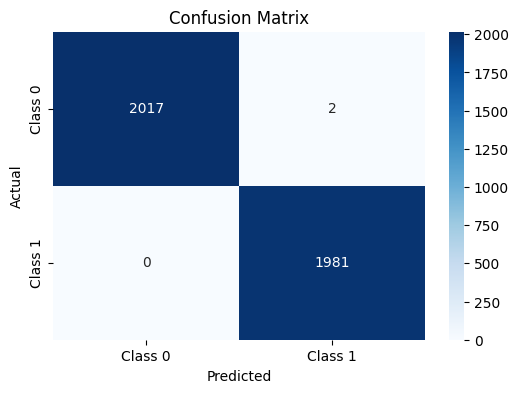

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.2f}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      2019
     Class 1       1.00      1.00      1.00      1981

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
ROC-AUC Score: 1.00
